In [47]:
import torch
from torchvision import models, transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

vgg = models.vgg19(pretrained=True).features
vgg.to(device)

print(vgg._modules)
for item in vgg.parameters():
    item.requires_grad_(False)

OrderedDict([('0', Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('1', ReLU(inplace=True)), ('2', Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('3', ReLU(inplace=True)), ('4', MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)), ('5', Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('6', ReLU(inplace=True)), ('7', Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('8', ReLU(inplace=True)), ('9', MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)), ('10', Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('11', ReLU(inplace=True)), ('12', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('13', ReLU(inplace=True)), ('14', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('15', ReLU(inplace=True)), ('16', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('17', ReLU(inplace=Tru

In [25]:
from io import BytesIO
import requests
from PIL import Image

def loadImage(imagePath, maxSize=400, shape=None):
    if 'http' in imagePath:
        response = requests.get(imagePath)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image =Image.open(imagePath).convert('RGB')
    
    size = maxSize if max(image.size) > maxSize else max(image.size)
    size = size if shape is None else shape
    
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
    ])
    
    #discharge transparent and add batch dimension
    in_transform = transform(image)[:3].unsqueeze(0)
    
    return in_transform
        

In [58]:
import numpy as np

def im_convert(tensor):
    image = tensor.to('cpu').clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229,0.224,0.225)) + np.array((0.485,0.456,0.406))
    image = image.clip(0,1)
    return image

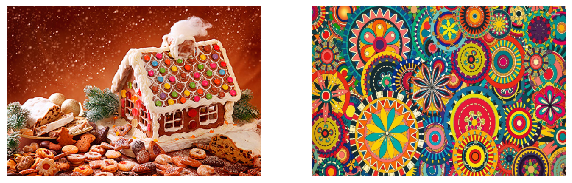

In [65]:
import matplotlib.pyplot as plt

content = loadImage('images/content.jpg').to(device)
style = loadImage('images/style.jpg', shape = content.shape[-2:]).to(device)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
ax1.axis('off')
ax2.axis('off')
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

In [93]:
def get_features(image, vgg, layer=None):
    if layer is None:
        layers = {
            '0': 'conv1_1',        
            '5': 'conv2_1',       
            '10': 'conv3_1',
            '19': 'conv4_1',        
            '21': 'conv4_2', #content representative   
            '28': 'conv5_1',
        }

    features = {}
    x = image
    for name, layer in vgg._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

In [102]:
def gram_matrix(tensor):
    _, d, w, h = tensor.size()
    tensor = tensor.view(d, w * h)
    gram = torch.mm(tensor, tensor.t())
    return gram

In [110]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

target = content.clone().requires_grad_(True).to(device)

In [124]:
style_weights = {
    'conv1_1': 1,
    'conv2_1': 0.75,
    'conv3_1': 0.5,
    'conv4_1': 0.25,
    'conv5_1': 0.1
}
    
content_weight = 1
style_weight = 1e6


{'conv1_1': 1, 'conv2_1': 0.75, 'conv3_1': 0.5, 'conv4_1': 0.25, 'conv5_1': 0.1}


In [133]:
import torch.optim as optim

optimizer = optim.Adam([target], lr = 0.003)

def transfer_style(step, show_every):
    for s in range(step):
        target_features = get_features(target,vgg)
        content_loss = torch.mean((target_features['conv4_2'] - style_features['conv4_2'])**2)

        style_loss = 0
        for layer in style_weights:
            target_feature = target_features[layer]
            target_gram = gram_matrix(target_feature)
            _,d,h,w = target_feature.shape
            layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_grams[layer])**2)
            style_loss += layer_style_loss / (d * w * h)
                
        total_loss = content_weight * content_loss + style_weight * style_loss
        
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        if (s+1) % show_every == 0:
            print('Total loss: ', total_loss.item())
            plt.imshow(im_convert(target))
            plt.show()


Total loss:  18595946496.0


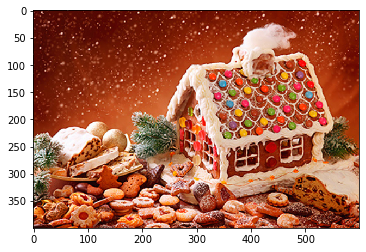

In [134]:
transfer_style(1,1)